# IV. Archive Classification

The primary question which we pursue in this section is how one can use reproducible and replicable workflows for discovering the optimal classifications of the text groups from the Drehem texts, found in an unprovenanced archival context. We describe how we leverage existing classification models to help validate our findings. 

In [ ]:
# import necessary libraries
import pandas as pd
from tqdm.auto import tqdm

# import libraries for this section
import re
import matplotlib.pyplot as plt

# import ML models from sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
# import train_test_split function
from sklearn.model_selection import train_test_split
from sklearn import metrics

## 1 Set up Data
Create a dictionary of archive categories

### 1.1 Labeling the Training Data

We will be labeling the data according to what words show up in it.

In [ ]:
labels = dict()
labels['domesticated_animal'] = ['ox', 'cow', 'sheep', 'goat', 'lamb', '~sheep', 'equid'] # account for plural
#split domesticated into large and small - sheep, goat, lamb, ~sheep would be small domesticated animals
labels['wild_animal'] = ['bear', 'gazelle', 'mountain'] # account for 'mountain animal' and plural
labels['dead_animal'] = ['die'] # find 'die' before finding domesticated or wild
labels['leather_object'] = ['boots', 'sandals']
labels['precious_object'] = ['copper', 'bronze', 'silver', 'gold']
labels['wool'] = ['wool', '~wool']
# labels['queens_archive'] = []

Using filtered_with_neighbors.csv generated above, make P Number and id_line the new indices.

Separate components of the lemma.

In [ ]:
words_df = pd.read_pickle('https://gitlab.com/yashila.bordag/sumnet-data/-/raw/main/part_3_words_output.p') # uncomment to read from online file
#words_df = pd.read_pickle('output/part_3_output.p') #uncomment to read from local file

In [ ]:
data = words_df.copy()
data.loc[:, 'pn'] = data.loc[:, 'id_text'].str[-6:].astype(int)
data = data.set_index(['pn', 'id_line']).sort_index()
extracted = data.loc[:, 'lemma'].str.extract(r'(\S+)\[(.*)\](\S+)')
data = pd.concat([data, extracted], axis=1)
data = data.fillna('') #.dropna() ????
data.head()

lemma  id_text      id_word  ...       0      1   2
pn     id_line                                      ...                   
100041 3          6(diš)[]NU  P100041  P100041.3.1  ...  6(diš)         NU
       3         udu[sheep]N  P100041  P100041.3.2  ...     udu  sheep   N
       4        kišib[seal]N  P100041  P100041.4.1  ...   kišib   seal   N
       4         Lusuen[0]PN  P100041  P100041.4.2  ...  Lusuen      0  PN
       5          ki[place]N  P100041  P100041.5.1  ...      ki  place   N

[5 rows x 31 columns]

In [ ]:
data['label'].value_counts()

o 1                  46955
o 2                  37850
o 3                  36878
r 3                  33824
o 4                  32289
                     ...  
env o 10                 1
o vii' 4                 1
o ii 50                  1
a i 9                    1
seal S000081 ii 4        1
Name: label, Length: 2032, dtype: int64

In [ ]:
for archive in labels.keys():
    data.loc[data.loc[:, 1].str.contains('|'.join([re.escape(x) for x in labels[archive]])), 'archive'] = archive

data.loc[:, 'archive'] = data.loc[:, 'archive'].fillna('')

data.head()

lemma  id_text  ...   2              archive
pn     id_line                         ...                         
100041 3          6(diš)[]NU  P100041  ...  NU                     
       3         udu[sheep]N  P100041  ...   N  domesticated_animal
       4        kišib[seal]N  P100041  ...   N                     
       4         Lusuen[0]PN  P100041  ...  PN                     
       5          ki[place]N  P100041  ...   N                     

[5 rows x 32 columns]

The function get_set has a dataframe row as an input and returns a dictionary where each key is a word type like NU and PN. The values are its corresponding lemmas.

### 1.2 Data Structuring

In [ ]:
def get_set(df):
    
    d = {}

    seals = df[df['label'].str.contains('seal')]
    df = df[~df['label'].str.contains('seal')]

    for x in df[2].unique():
        d[x] = set(df.loc[df[2] == x, 0])

    d['SEALS'] = {}
    for x in seals[2].unique():
        d['SEALS'][x] = set(seals.loc[seals[2] == x, 0])

    return d

In [ ]:
get_set(data.loc[100271])

{'': {''},
 'MN': {'Šueša'},
 'N': {'itud', 'maš', 'mu', 'mu.DU', 'udu'},
 'NU': {'1(diš)', '2(diš)'},
 'PN': {'Apilatum', 'Ku.ru.ub.er₃', 'Šulgisimti'},
 'SEALS': {},
 'SN': {'Šašrum'},
 'V/i': {'hulu'},
 'V/t': {'dab'}}

In [ ]:
archives = pd.DataFrame(data.groupby('pn').apply(lambda x: set(x['archive'].unique()) - set(['']))).rename(columns={0: 'archive'})
archives.loc[:, 'set'] = data.reset_index().groupby('pn').apply(get_set)
archives.loc[:, 'archive'] = archives.loc[:, 'archive'].apply(lambda x: {'dead_animal'} if 'dead_animal' in x else x)
archives.head()

,archive,set
pn,,
100041,{domesticated_animal},"{'NU': {'6(diš)'}, 'N': {'ki', 'kišib', 'udu'}..."
100189,{dead_animal},"{'NU': {'1(diš)', '5(diš)-kam', '2(diš)'}, 'N'..."
100190,{dead_animal},"{'NU': {'3(u)', '1(diš)', '5(diš)', '1(diš)-ka..."
100191,{dead_animal},"{'NU': {'1(diš)', '4(diš)', '4(diš)-kam', '2(u..."
100211,{dead_animal},"{'NU': {'1(diš)', '1(u)', '1(diš)-kam', '2(diš..."


In [ ]:
def get_line(row, pos_lst=['N']):
    words = {'pn' : [row.name]} #set p_number
    for pos in pos_lst:
        if pos in row['set']:
            #add word entries for all words of the selected part of speech
            words.update({word: [1] for word in row['set'][pos]})
    return pd.DataFrame(words)

Each row represents a unique P-number, so the matrix indicates which word are present in each text.

In [ ]:
sparse = words_df.groupby(by=['id_text', 'lemma']).count()
sparse = sparse['id_word'].unstack('lemma')
sparse = sparse.fillna(0)

In [ ]:
sparse = pd.concat(archives.apply(get_line, axis=1).values).set_index('pn')

sparse

,ki,kišib,udu,itud,mu,ud,ga,sila,šu,mu.DU,maškim,ekišibak,zabardab,u,maš,šag,lugal,mašgal,kir,a,en,ensik,egia,igikar,ŋiri,ragaba,dubsar,mašda,saŋŋa,amar,mada,akiti,lu,ab,gud,ziga,uzud,ašgar,gukkal,šugid,...,šaŋanla,pukutum,lagaztum,bangi,imdua,KU.du₃,batiʾum,niŋna,sikiduʾa,gudumdum,šuhugari,šutur,gaguru,nindašura,ekaskalak,usaŋ,nammah,egizid,nisku,gara,saŋ.DUN₃,muhaldimgal,šagiagal,šagiamah,kurunakgal,ugulaʾek,šidimgal,kalam,enkud,in,kiʾana,bahar,hurizum,lagab,ibadu,balla,šembulug,li,niŋsaha,ensi
pn,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100041,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100189,1.0,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100190,1.0,NaN,1.0,1.0,1.0,1.0,NaN,1.0,NaN,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100191,1.0,NaN,1.0,1.0,1.0,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100211,1.0,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
519650,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
519658,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
519792,NaN,NaN,1.0,1.0,1.0,1.0,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN,1.0,NaN,1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
sparse = sparse.fillna(0)
sparse = sparse.join(archives.loc[:, 'archive'])

In [ ]:
sparse.loc[sparse.loc[:, 'archive'].apply(lambda x: 'domesticated_animal' in x), 'domesticated_animal'] = 1
sparse.loc[:, 'domesticated_animal'] = sparse.loc[:, 'domesticated_animal'].fillna(0)

sparse.loc[sparse.loc[:, 'archive'].apply(lambda x: 'wild_animal' in x), 'wild_animal'] = 1
sparse.loc[:, 'wild_animal'] = sparse.loc[:, 'wild_animal'].fillna(0)

sparse.loc[sparse.loc[:, 'archive'].apply(lambda x: 'dead_animal' in x), 'dead_animal'] = 1
sparse.loc[:, 'dead_animal'] = sparse.loc[:, 'dead_animal'].fillna(0)

sparse.loc[sparse.loc[:, 'archive'].apply(lambda x: 'leather_object' in x), 'leather_object'] = 1
sparse.loc[:, 'leather_object'] = sparse.loc[:, 'leather_object'].fillna(0)

sparse.loc[sparse.loc[:, 'archive'].apply(lambda x: 'precious_object' in x), 'precious_object'] = 1
sparse.loc[:, 'precious_object'] = sparse.loc[:, 'precious_object'].fillna(0)

sparse.loc[sparse.loc[:, 'archive'].apply(lambda x: 'wool' in x), 'wool'] = 1
sparse.loc[:, 'wool'] = sparse.loc[:, 'wool'].fillna(0)
sparse.head()

,ki,kišib,udu,itud,mu,ud,ga,sila,šu,mu.DU,maškim,ekišibak,zabardab,u,maš,šag,lugal,mašgal,kir,a,en,ensik,egia,igikar,ŋiri,ragaba,dubsar,mašda,saŋŋa,amar,mada,akiti,lu,ab,gud,ziga,uzud,ašgar,gukkal,šugid,...,niŋna,sikiduʾa,gudumdum,šuhugari,šutur,gaguru,nindašura,ekaskalak,usaŋ,nammah,egizid,nisku,gara,saŋ.DUN₃,muhaldimgal,šagiagal,šagiamah,kurunakgal,ugulaʾek,šidimgal,kalam,enkud,in,kiʾana,bahar,hurizum,lagab,ibadu,balla,šembulug,li,niŋsaha,ensi,archive,domesticated_animal,wild_animal,dead_animal,leather_object,precious_object,wool
pn,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100041,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,{domesticated_animal},1.0,0.0,0.0,0.0,0.0,0.0
100189,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,{dead_animal},0.0,0.0,1.0,0.0,0.0,0.0
100190,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,{dead_animal},0.0,0.0,1.0,0.0,0.0,0.0
100191,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,{dead_animal},0.0,0.0,1.0,0.0,0.0,0.0
100211,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,{dead_animal},0.0,0.0,1.0,0.0,0.0,0.0


In [ ]:
known = sparse.loc[sparse['archive'].apply(len) == 1, :]
unknown = sparse.loc[(sparse['archive'].apply(len) == 0) | (sparse['archive'].apply(len) > 1), :]

In [ ]:
unknown_0 = sparse.loc[(sparse['archive'].apply(len) == 0), :]

In [ ]:
unknown.shape

(3243, 1083)

### 1.3 Data Exploration

In [ ]:
unknown.loc[sparse['archive'].apply(len) > 1, :]

,ki,kišib,udu,itud,mu,ud,ga,sila,šu,mu.DU,maškim,ekišibak,zabardab,u,maš,šag,lugal,mašgal,kir,a,en,ensik,egia,igikar,ŋiri,ragaba,dubsar,mašda,saŋŋa,amar,mada,akiti,lu,ab,gud,ziga,uzud,ašgar,gukkal,šugid,...,niŋna,sikiduʾa,gudumdum,šuhugari,šutur,gaguru,nindašura,ekaskalak,usaŋ,nammah,egizid,nisku,gara,saŋ.DUN₃,muhaldimgal,šagiagal,šagiamah,kurunakgal,ugulaʾek,šidimgal,kalam,enkud,in,kiʾana,bahar,hurizum,lagab,ibadu,balla,šembulug,li,niŋsaha,ensi,archive,domesticated_animal,wild_animal,dead_animal,leather_object,precious_object,wool
pn,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100217,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"{domesticated_animal, wild_animal}",1.0,1.0,0.0,0.0,0.0,0.0
100229,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"{domesticated_animal, wild_animal}",1.0,1.0,0.0,0.0,0.0,0.0
100284,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"{domesticated_animal, wild_animal}",1.0,1.0,0.0,0.0,0.0,0.0
100330,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"{domesticated_animal, wild_animal}",1.0,1.0,0.0,0.0,0.0,0.0
100749,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"{domesticated_animal, wild_animal}",1.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
500210,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"{domesticated_animal, wild_animal}",1.0,1.0,0.0,0.0,0.0,0.0
507968,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"{domesticated_animal, wild_animal}",1.0,1.0,0.0,0.0,0.0,0.0
509325,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"{domesticated_animal, wild_animal}",1.0,1.0,0.0,0.0,0.0,0.0


In [ ]:
#find rows where archive has empty set
unknown[unknown['archive'] == set()]

,ki,kišib,udu,itud,mu,ud,ga,sila,šu,mu.DU,maškim,ekišibak,zabardab,u,maš,šag,lugal,mašgal,kir,a,en,ensik,egia,igikar,ŋiri,ragaba,dubsar,mašda,saŋŋa,amar,mada,akiti,lu,ab,gud,ziga,uzud,ašgar,gukkal,šugid,...,niŋna,sikiduʾa,gudumdum,šuhugari,šutur,gaguru,nindašura,ekaskalak,usaŋ,nammah,egizid,nisku,gara,saŋ.DUN₃,muhaldimgal,šagiagal,šagiamah,kurunakgal,ugulaʾek,šidimgal,kalam,enkud,in,kiʾana,bahar,hurizum,lagab,ibadu,balla,šembulug,li,niŋsaha,ensi,archive,domesticated_animal,wild_animal,dead_animal,leather_object,precious_object,wool
pn,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100292,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,{},0.0,0.0,0.0,0.0,0.0,0.0
100301,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,{},0.0,0.0,0.0,0.0,0.0,0.0
100375,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,{},0.0,0.0,0.0,0.0,0.0,0.0
100376,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,{},0.0,0.0,0.0,0.0,0.0,0.0
100377,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,{},0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
519647,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,{},0.0,0.0,0.0,0.0,0.0,0.0
519650,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,{},0.0,0.0,0.0,0.0,0.0,0.0
519658,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,{},0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
known_copy = known
known_archives = [known_copy['archive'].to_list()[i].pop() for i in range(len(known_copy['archive'].to_list()))]
known_archives

['domesticated_animal',
 'dead_animal',
 'dead_animal',
 'dead_animal',
 'dead_animal',
 'domesticated_animal',
 'domesticated_animal',
 'domesticated_animal',
 'domesticated_animal',
 'domesticated_animal',
 'domesticated_animal',
 'domesticated_animal',
 'dead_animal',
 'dead_animal',
 'domesticated_animal',
 'dead_animal',
 'dead_animal',
 'dead_animal',
 'dead_animal',
 'domesticated_animal',
 'domesticated_animal',
 'domesticated_animal',
 'wild_animal',
 'domesticated_animal',
 'domesticated_animal',
 'domesticated_animal',
 'dead_animal',
 'domesticated_animal',
 'domesticated_animal',
 'dead_animal',
 'dead_animal',
 'domesticated_animal',
 'domesticated_animal',
 'domesticated_animal',
 'domesticated_animal',
 'domesticated_animal',
 'dead_animal',
 'dead_animal',
 'dead_animal',
 'domesticated_animal',
 'domesticated_animal',
 'domesticated_animal',
 'domesticated_animal',
 'domesticated_animal',
 'dead_animal',
 'domesticated_animal',
 'domesticated_animal',
 'domesticated_a

In [ ]:
known['archive_class'] = known_archives

Percent of texts in Domesticated Animal Archive: 0.6905682582380632


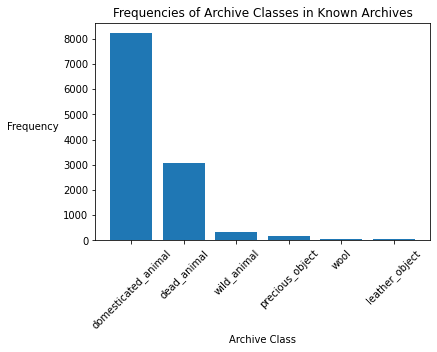

In [ ]:
archive_counts = known['archive_class'].value_counts()


plt.xlabel('Archive Class')
plt.ylabel('Frequency', rotation=0, labelpad=30)
plt.title('Frequencies of Archive Classes in Known Archives')
plt.xticks(rotation=45)
plt.bar(archive_counts.index, archive_counts);

percent_domesticated_animal = archive_counts['domesticated_animal'] / sum(archive_counts)

print('Percent of texts in Domesticated Animal Archive:', percent_domesticated_animal)

In [ ]:
known.shape

(11896, 1084)

In [ ]:
words_df_copy = words_df.copy()
words_df_copy['id_text'] = [int(pn[1:]) for pn in words_df_copy['id_text']]

grouped = words_df_copy.groupby(by=['id_text']).first()
grouped = grouped.fillna(0)

known_copy = known.copy()
known_copy['year'] = grouped.loc[grouped.index.isin(known.index),:]['min_year']

year_counts = known_copy.groupby(by=['year', 'archive_class'], as_index=False).count().set_index('year').loc[:, 'archive_class':'ki']
year_counts_pivoted = year_counts.pivot(columns='archive_class', values='ki').fillna(0)

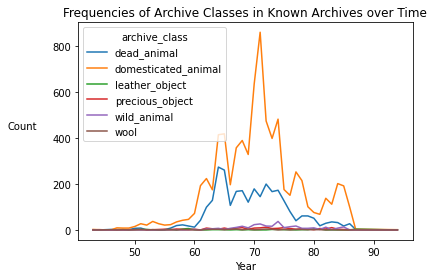

In [ ]:
year_counts_pivoted.drop(index=0).plot();
plt.xlabel('Year')
plt.ylabel('Count', rotation=0, labelpad=30)
plt.title('Frequencies of Archive Classes in Known Archives over Time');

In [ ]:
known

,ki,kišib,udu,itud,mu,ud,ga,sila,šu,mu.DU,maškim,ekišibak,zabardab,u,maš,šag,lugal,mašgal,kir,a,en,ensik,egia,igikar,ŋiri,ragaba,dubsar,mašda,saŋŋa,amar,mada,akiti,lu,ab,gud,ziga,uzud,ašgar,gukkal,šugid,...,sikiduʾa,gudumdum,šuhugari,šutur,gaguru,nindašura,ekaskalak,usaŋ,nammah,egizid,nisku,gara,saŋ.DUN₃,muhaldimgal,šagiagal,šagiamah,kurunakgal,ugulaʾek,šidimgal,kalam,enkud,in,kiʾana,bahar,hurizum,lagab,ibadu,balla,šembulug,li,niŋsaha,ensi,archive,domesticated_animal,wild_animal,dead_animal,leather_object,precious_object,wool,archive_class
pn,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100041,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,{},1.0,0.0,0.0,0.0,0.0,0.0,domesticated_animal
100189,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,{},0.0,0.0,1.0,0.0,0.0,0.0,dead_animal
100190,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,{},0.0,0.0,1.0,0.0,0.0,0.0,dead_animal
100191,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,{},0.0,0.0,1.0,0.0,0.0,0.0,dead_animal
100211,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,{},0.0,0.0,1.0,0.0,0.0,0.0,dead_animal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
514376,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,{},1.0,0.0,0.0,0.0,0.0,0.0,domesticated_animal
517184,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,{},0.0,0.0,1.0,0.0,0.0,0.0,dead_animal
519457,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,{},1.0,0.0,0.0,0.0,0.0,0.0,domesticated_animal


In [ ]:
#run to save the prepared data
known.to_csv('output/part_4_known.csv')
known.to_pickle('output/part_4_known.p')
unknown.to_csv('output/part_4_unknown.csv')
unknown.to_pickle('output/part_4_unknown.p')
unknown_0.to_csv('output/part_4_unknown_0.csv')
unknown_0.to_pickle('output/part_4_unknown_0.p')

In [ ]:
#known = pd.read_pickle('https://gitlab.com/yashila.bordag/sumnet-data/-/raw/main/part_4_known.p')
#unknown = pd.read_pickle('https://gitlab.com/yashila.bordag/sumnet-data/-/raw/main/part_4_unknown.p')
#unknown_0 = pd.read_pickle('https://gitlab.com/yashila.bordag/sumnet-data/-/raw/main/part_4_unknown_0.p')

model_weights = {}

#### 1.3.1 PCA/Dimensionality Reduction

Here we perform PCA to find out more about the underlying structure of the dataset. We will analyze the 2 most important principle components and explore how much of the variation of the known set is due to these components.

In [ ]:
#PCA
pca_archive = PCA()
principalComponents_archive = pca_archive.fit_transform(known.loc[:, 'AN.bu.um':'šuʾura'])

In [ ]:
principal_archive_Df = pd.DataFrame(data = principalComponents_archive
             , columns = ['principal component ' + str(i) for i in range(1, 1 + len(principalComponents_archive[0]))])

In [ ]:
len(known.loc[:, 'AN.bu.um':'šuʾura'].columns)

69

In [ ]:
principal_archive_Df

,principal component 1,principal component 2,principal component 3,principal component 4,principal component 5,principal component 6,principal component 7,principal component 8,principal component 9,principal component 10,principal component 11,principal component 12,principal component 13,principal component 14,principal component 15,principal component 16,principal component 17,principal component 18,principal component 19,principal component 20,principal component 21,principal component 22,principal component 23,principal component 24,principal component 25,principal component 26,principal component 27,principal component 28,principal component 29,principal component 30,principal component 31,principal component 32,principal component 33,principal component 34,principal component 35,principal component 36,principal component 37,principal component 38,principal component 39,principal component 40,principal component 41,principal component 42,principal component 43,principal component 44,principal component 45,principal component 46,principal component 47,principal component 48,principal component 49,principal component 50,principal component 51,principal component 52,principal component 53,principal component 54,principal component 55,principal component 56,principal component 57,principal component 58,principal component 59,principal component 60,principal component 61,principal component 62,principal component 63,principal component 64,principal component 65,principal component 66,principal component 67,principal component 68,principal component 69
0,-0.001153,-0.000651,-0.000559,-0.000524,0.00003,0.000357,-0.000339,-0.000428,-0.000424,-0.000372,-0.000382,-5.157586e-17,2.706112e-15,-0.000481,-0.000306,0.000033,-3.429768e-16,5.923137e-17,4.357782e-17,-2.465750e-16,2.860153e-16,-0.000624,3.966646e-17,2.603275e-16,-4.583354e-17,-2.646101e-17,8.451599e-18,-3.045379e-17,1.346336e-17,9.688025e-17,1.936758e-17,-0.00051,0.000105,-0.000049,-0.000055,-0.000027,-0.000113,-0.000011,-0.000028,-0.000117,-1.617357e-16,-0.000085,-0.000069,-0.000107,0.000015,-0.000031,-0.000042,1.970750e-15,1.869525e-17,9.415297e-16,2.019903e-15,-1.169278e-18,1.894373e-20,-7.211354e-21,-2.128106e-20,1.746307e-21,-2.687171e-20,-2.849700e-20,2.445157e-21,1.963535e-20,3.486655e-21,-2.377182e-22,1.506376e-20,1.319668e-21,-2.913316e-23,4.035962e-23,-2.844907e-23,5.776068e-23,-3.962093e-21
1,-0.001153,-0.000651,-0.000559,-0.000524,0.00003,0.000357,-0.000339,-0.000428,-0.000424,-0.000372,-0.000382,1.564922e-16,2.649608e-15,-0.000481,-0.000306,0.000033,-2.727474e-16,-3.278168e-17,-2.041174e-17,1.211487e-16,4.041074e-17,-0.000624,1.172185e-16,2.181246e-17,3.816922e-17,-1.415496e-17,-8.185121e-17,1.835050e-16,-2.723499e-16,1.982747e-16,-1.303244e-16,-0.00051,0.000105,-0.000049,-0.000055,-0.000027,-0.000113,-0.000011,-0.000028,-0.000117,-6.575466e-17,-0.000085,-0.000069,-0.000107,0.000015,-0.000031,-0.000042,9.619220e-15,-6.600049e-17,-1.429446e-16,-1.916333e-16,-4.540458e-17,3.457458e-19,-6.477865e-19,3.464390e-19,-1.141279e-19,2.092593e-19,1.045044e-18,1.123598e-18,-1.462768e-18,1.294085e-18,4.663841e-19,-3.597813e-19,-4.046188e-20,-1.200163e-20,-1.178408e-20,-6.275206e-21,-1.761853e-20,6.692983e-20
2,-0.001153,-0.000651,-0.000559,-0.000524,0.00003,0.000357,-0.000339,-0.000428,-0.000424,-0.000372,-0.000382,1.535254e-16,2.658846e-15,-0.000481,-0.000306,0.000033,-2.825484e-16,-3.280272e-17,-2.539356e-17,1.231791e-16,4.753436e-17,-0.000624,1.205493e-16,2.333757e-17,3.548553e-17,-1.480301e-17,-8.340641e-17,1.838694e-16,-2.681072e-16,1.870916e-16,-1.443350e-16,-0.00051,0.000105,-0.000049,-0.000055,-0.000027,-0.000113,-0.000011,-0.000028,-0.000117,-6.308277e-17,-0.000085,-0.000069,-0.000107,0.000015,-0.000031,-0.000042,9.504357e-15,-6.459051e-17,-1.301681e-16,-1.933703e-16,-3.696746e-17,1.681898e-19,-6.751741e-19,4.477259e-19,-7.269816e-20,4.045474e-19,1.223637e-18,1.075851e-18,-1.593793e-18,1.216670e-18,2.723570e-19,-4.703521e-19,3.232220e-19,7.222399e-21,5.820028e-21,5

In [ ]:
principal_archive_Df.shape

(11884, 69)

In [ ]:
print('Explained variation per principal component: {}'.format(pca_archive.explained_variance_ratio_))

Explained variation per principal component: [1.48909600e-01 7.68896157e-02 5.44580086e-02 3.84859466e-02
 3.73441272e-02 3.55736929e-02 3.34908306e-02 3.23180930e-02
 3.08607958e-02 2.72465476e-02 2.62104855e-02 2.46991069e-02
 2.46991069e-02 2.46822947e-02 2.23337377e-02 1.90080231e-02
 1.85243302e-02 1.85243302e-02 1.85243302e-02 1.85243302e-02
 1.85243302e-02 1.84959965e-02 1.23495535e-02 1.23495535e-02
 1.23495535e-02 1.23495535e-02 1.23495535e-02 1.23495535e-02
 1.23495535e-02 1.23495535e-02 1.23495535e-02 1.23306530e-02
 1.17690579e-02 1.08917149e-02 1.05830913e-02 9.79182442e-03
 9.66057258e-03 8.53332346e-03 8.13466952e-03 7.97584503e-03
 6.17477673e-03 6.17425099e-03 4.86154090e-03 4.81603581e-03
 4.71709331e-03 2.85814508e-03 1.25376384e-03 1.15905668e-30
 3.84394984e-31 3.83344024e-32 3.01169726e-32 4.83032948e-33
 7.20704280e-34 7.20704280e-34 7.20704280e-34 7.20704280e-34
 7.20704280e-34 7.20704280e-34 7.20704280e-34 7.20704280e-34
 7.20704280e-34 7.20704280e-34 7.2070428

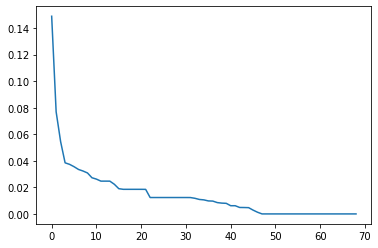

In [ ]:
plt.plot(pca_archive.explained_variance_ratio_)

In [ ]:
known_reindexed = known.reset_index()
known_reindexed

In [ ]:
plt.figure()
plt.figure(figsize=(10,10))
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel('Principal Component 1',fontsize=20)
plt.ylabel('Principal Component 2',fontsize=20)
plt.title("Principal Component Analysis of Archives",fontsize=20)
targets = ['domesticated_animal', 'wild_animal', 'dead_animal', 'leather_object', 'precious_object', 'wool']
colors = ['red', 'orange', 'yellow', 'green', 'blue', 'violet']
for target, color in zip(targets,colors):
    indicesToKeep = known_reindexed.index[known_reindexed['archive_class'] == target].tolist()
    plt.scatter(principal_archive_Df.loc[indicesToKeep, 'principal component 1']
               , principal_archive_Df.loc[indicesToKeep, 'principal component 2'], c = color, s = 50)

plt.legend(targets,prop={'size': 15})

# import seaborn as sns
# plt.figure(figsize=(16,10))
# sns.scatterplot(
#     x="principal component 1", y="principal component 2",
#     hue="y",
#     palette=sns.color_palette("hls", 10),
#     data=principal_cifar_Df,
#     legend="full",
#     alpha=0.3
# )

## 2 Simple Modeling Methods

### 2.1 Logistic Regression

Here we will train our model using logistic regression to predict archives based on the features made in the previous subsection.

#### 2.1.1 Logistic Regression by Archive

Here we will train and test a set of 1 vs all Logistic Regression Classifiers which will attempt to classify tablets as either a part of an archive, or not in an archive.

In [ ]:
clf_da = LogisticRegression(random_state=42, solver='lbfgs', max_iter=200)
clf_da.fit(known.loc[:, 'AN.bu.um':'šuʾura'], known.loc[:, 'domesticated_animal'])
clf_da.score(known.loc[:, 'AN.bu.um':'šuʾura'], known.loc[:, 'domesticated_animal'])

In [ ]:
clf_wa = LogisticRegression(random_state=42, solver='lbfgs', max_iter=200)
clf_wa.fit(known.loc[:, 'AN.bu.um':'šuʾura'], known.loc[:, 'wild_animal'])
clf_wa.score(known.loc[:, 'AN.bu.um':'šuʾura'], known.loc[:, 'wild_animal'])

In [ ]:
clf_dea = LogisticRegression(random_state=42, solver='lbfgs', max_iter=200)
clf_dea.fit(known.loc[:, 'AN.bu.um':'šuʾura'], known.loc[:, 'dead_animal'])
clf_dea.score(known.loc[:, 'AN.bu.um':'šuʾura'], known.loc[:, 'dead_animal'])

In [ ]:
clf_lo = LogisticRegression(random_state=42, solver='lbfgs', max_iter=200)
clf_lo.fit(known.loc[:, 'AN.bu.um':'šuʾura'], known.loc[:, 'leather_object'])
clf_lo.score(known.loc[:, 'AN.bu.um':'šuʾura'], known.loc[:, 'leather_object'])

In [ ]:
clf_po = LogisticRegression(random_state=42, solver='lbfgs', max_iter=200)
clf_po.fit(known.loc[:, 'AN.bu.um':'šuʾura'], known.loc[:, 'precious_object'])
clf_po.score(known.loc[:, 'AN.bu.um':'šuʾura'], known.loc[:, 'precious_object'])

In [ ]:
clf_w = LogisticRegression(random_state=42, solver='lbfgs', max_iter=200)
clf_w.fit(known.loc[:, 'AN.bu.um':'šuʾura'], known.loc[:, 'wool'])
clf_w.score(known.loc[:, 'AN.bu.um':'šuʾura'], known.loc[:, 'wool'])

In [ ]:
known.loc[:, 'AN.bu.um':'šuʾura']

As we can see the domesticated animal model has the lowest accuracy while the leather object, precious_object, and wool classifiers work fairly well.

#### 2.1.2 Multinomial Logistic Regression

Here we will be using multinomial logistic regression as we have multiple archive which we could classify each text into. We are fitting our data onto the tablets with known archives and then checking the score to see how accurate the model is.

Finally, we append the Logistic Regression prediction as an archive prediction for the tablets without known archives.

In [ ]:
clf_archive = LogisticRegression(random_state=42, solver='lbfgs', max_iter=300)
clf_archive.fit(known.loc[:, 'AN.bu.um':'šuʾura'], known.loc[:, 'archive_class'])
log_reg_score = clf_archive.score(known.loc[:, 'AN.bu.um':'šuʾura'], known.loc[:, 'archive_class'])
model_weights['LogReg'] = log_reg_score
log_reg_score

0.6918291862811029

In [ ]:
#Predictions for Unknown
unknown["LogReg Predicted Archive"] = clf_archive.predict(unknown.loc[:, 'AN.bu.um':'šuʾura'])
unknown

,ki,kišib,udu,itud,mu,ud,ga,sila,šu,mu.DU,maškim,ekišibak,zabardab,u,maš,šag,lugal,mašgal,kir,a,en,ensik,egia,igikar,ŋiri,ragaba,dubsar,mašda,saŋŋa,amar,mada,akiti,lu,ab,gud,ziga,uzud,ašgar,gukkal,šugid,...,sikiduʾa,gudumdum,šuhugari,šutur,gaguru,nindašura,ekaskalak,usaŋ,nammah,egizid,nisku,gara,saŋ.DUN₃,muhaldimgal,šagiagal,šagiamah,kurunakgal,ugulaʾek,šidimgal,kalam,enkud,in,kiʾana,bahar,hurizum,lagab,ibadu,balla,šembulug,li,niŋsaha,ensi,archive,domesticated_animal,wild_animal,dead_animal,leather_object,precious_object,wool,LogReg Predicted Archive
pn,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100217,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"{domesticated_animal, wild_animal}",1.0,1.0,0.0,0.0,0.0,0.0,domesticated_animal
100229,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"{domesticated_animal, wild_animal}",1.0,1.0,0.0,0.0,0.0,0.0,domesticated_animal
100284,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"{domesticated_animal, wild_animal}",1.0,1.0,0.0,0.0,0.0,0.0,domesticated_animal
100292,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,{},0.0,0.0,0.0,0.0,0.0,0.0,domesticated_animal
100301,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,{},0.0,0.0,0.0,0.0,0.0,0.0,domesticated_animal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
519647,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,{},0.0,0.0,0.0,0.0,0.0,0.0,domesticated_animal
519650,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,{},0.0,0.0,0.0,0.0,0.0,0.0,domesticated_animal
519658,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,{},0.0,0.0,0.0,0.0,0.0,0.0,domesticated_animal


In [ ]:
known['archive_class'].unique()

### 2.2 K Nearest Neighbors

Here we will train our model using k nearest neighbors to predict archives based on the features made in the previous subsection. We are fitting our data onto the tablets with known archives and then checking the score to see how accurate the model is.

We then append the KNN prediction as an archive prediction for the tablets without known archives.

Then, we use different values for K (the number of neighbors we take into consideration when predicting for a tablet) to see how the accuracy changes for different values of K. This can be seen as a form of hyperparameter tuning because we are trying to see which K we should choose to get the highest training accuracy.

In [ ]:
#takes long time to run, so don't run again
list_k = [3, 5, 7, 9, 11, 13]
max_k, max_score = 0, 0
for k in list_k:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(known.loc[:, 'AN.bu.um':'šuʾura'], known.loc[:, 'archive_class'])
    knn_score = knn.score(known.loc[:, 'AN.bu.um':'šuʾura'], known.loc[:, 'archive_class'])
    print("Accuracy for k = %s: " %(k), knn_score)
    if max_score <= knn_score:
        max_score = knn_score
        max_k = k
    

As we can see here, k = 5 and k = 9 have the best training accuracy performance which falls roughly in line with the Logistic Regression classification training accuracy.

In [ ]:
knn = KNeighborsClassifier(n_neighbors=max_k)
knn.fit(known.loc[:, 'AN.bu.um':'šuʾura'], known.loc[:, 'archive_class'])
knn_score = knn.score(known.loc[:, 'AN.bu.um':'šuʾura'], known.loc[:, 'archive_class'])
model_weights['KNN'] = knn_score

In [ ]:
#Predictions for Unknown
unknown["KNN Predicted Archive"] = knn.predict(unknown.loc[:, 'AN.bu.um':'šuʾura'])
unknown

As we can see in the output from the previous cell, we can get different predictions depending on the classifier we choose.

Next we will split the data we have on tablets with known archives into a test and training set to further understant the atraining accuracy. For the next two sections, we will use `X_train` and `y_train` to train the data and `X_test` and `y_test` to test the data. As the known set was split randomly, we presume that both the training and test set are representative of the whole known set, so the two sets are reasonably comparable.

In [ ]:
#Split known into train and test, eventually predict with unknown 
X_train, X_test, y_train, y_test = train_test_split(known.loc[:, 'AN.bu.um':'šuʾura'], 
                                                    known.loc[:, 'archive_class'], 
                                                    test_size=0.2,random_state=0) 

### 2.3 Naive Bayes

Here we will train our model using a Naive Bayes Model to predict archives based on the features made in the previous subsection. Here, we make the assumption that the features are independent of each other, from which the descriptor _naive_ comes from. So:

$$P(x_i|y; x_1, x_2, ..., x_{i-1}, x_{i+1}, ..., x_n) = P(x_i| y)$$

and:

$$P(x_1, x_2, ..., x_n | y) = \prod_{i=1}^{n} P(x_i | y)$$

Moreover, we will be using Bayes' Law, which in this case states:

$$P(y|x_1, x_2, ..., x_n) = \frac{P(y)P(x_1, x_2, ..., x_n | y)}{P(x_1, x_2, ..., x_n)}$$

eg. the probability of a particular tablet (defined by features $x_1, x_2, ..., x_n$) is in archive $y$, is equal to the probability of getting a tablet from archive $y$ times the probability you would get a particular set of features $x_1, x_2, ..., x_n$ divided by the probability of getting a particular set of features $x_1, x_2, ..., x_n$.

Applying our assumption of independence from before, we can simplify this to:

$$P(y|x_1, x_2, ..., x_n) = \frac{P(y)\prod_{i=1}^{n} P(x_i | y)}{P(x_1, x_2, ..., x_n)}$$

Which means the probability of a particular tablet (defined by features $x_1, x_2, ..., x_n$) is in archive $y$ is _proportional_ to 

$$P(y|x_1, x_2, ..., x_n) \propto P(y)\prod_{i=1}^{n} P(x_i | y)$$ probability of getting a tablet from archive $y$ times the product of probabilities of getting a feature $x_i$ given an archive $y$.

We can then use this to calculate the maximizing archive.

$$\hat{y} = \underset{y}{argmax} \; P(y)\prod_{i=1}^{n} P(x_i | y)$$

We are training two models where the first assumes the features are Gaussian random variables and the second assumes the features are Bernoulli random variables.

We are fitting our data onto the tablets with known archives and then checking the score to see how accurate the model is.

Finally, we append the two Naive Bayes predictions as archive predictions for the tablets without known archives.

In [ ]:
#Gaussian
gauss = GaussianNB()
gauss.fit(X_train, y_train)
gauss_nb_score = gauss.score(X_test, y_test)
model_weights['GaussNB'] = gauss_nb_score
gauss_nb_score

We can see than the Gaussian assumption does quite poorly.

In [ ]:
#Predictions for Unknown
unknown["GaussNB Predicted Archive"] = gauss.predict(unknown.loc[:, 'AN.bu.um':'šuʾura'])
unknown

In [ ]:
#Bernoulli
bern = BernoulliNB()
bern.fit(X_train, y_train)
bern_nb_score = bern.score(X_test, y_test)
model_weights['BernoulliNB'] = bern_nb_score
bern_nb_score

However the Bernoulli assumption does quite well.

In [ ]:
#Predictions for Unknown
unknown["BernoulliNB Predicted Archive"] = bern.predict(unknown.loc[:, 'AN.bu.um':'šuʾura'])
unknown

### 2.4 SVM

Here we will train our model using Support Vector Machines to predict archives based on the features made earlier in this section. We are fitting our data onto the tablets with known archives and then checking the score to see how accurate the model is.

Finally, we append the SVM prediction as an archive prediction for the tablets without known archives.

In [ ]:
svm_archive = svm.SVC(kernel='linear')
svm_archive.fit(X_train, y_train)
y_pred = svm_archive.predict(X_test)
svm_score = metrics.accuracy_score(y_test, y_pred)
model_weights['SVM'] = svm_score
print("Accuracy:", svm_score)

In [ ]:
unknown["SVM Predicted Archive"] = svm_archive.predict(unknown.loc[:, 'AN.bu.um':'šuʾura'])
unknown

## 3 Complex Modeling Methods

## 4 Voting Mechanism Between Models

Here we will use the models to determine the archive which to assign to each tablet with an unknown archive. 

We will then augment the words_df with these archives.

In [ ]:
model_weights

In [ ]:
def visualize_archives(data, prediction_name):
    archive_counts = data.value_counts()


    plt.xlabel('Archive Class')
    plt.ylabel('Frequency', rotation=0, labelpad=30)
    plt.title('Frequencies of ' + prediction_name + ' Predicted Archives')
    plt.xticks(rotation=45)
    plt.bar(archive_counts.index, archive_counts);

    percent_domesticated_animal = archive_counts['domesticated_animal'] / sum(archive_counts)

    print('Percent of texts in Domesticated Animal Archive:', percent_domesticated_animal)

In [ ]:
#Log Reg Predictions
visualize_archives(unknown['LogReg Predicted Archive'], 'Logistic Regression')

In [ ]:
#KNN Predictions
visualize_archives(unknown['KNN Predicted Archive'], 'K Nearest Neighbors')

In [ ]:
#Gaussian Naive Bayes Predictions
visualize_archives(unknown['GaussNB Predicted Archive'], 'Gaussian Naive Bayes')

In [ ]:
#Bernoulli Naive Bayes Predictions
visualize_archives(unknown['BernoulliNB Predicted Archive'], 'Bernoulli Naive Bayes')

In [ ]:
#SVM Predictions
visualize_archives(unknown['SVM Predicted Archive'], 'Support Vector Machines Naive Bayes')

In [ ]:
def weighted_voting(row):
    votes = {} # create empty voting dictionary
    # tally votes
    for model in row.index:
        model_name = model[:-18] # remove ' Predicted Archive' from column name
        prediction = row[model]
        if prediction not in votes.keys():
            votes[prediction] = model_weights[model_name] # if the prediction isn't in the list of voting categories, add it with a weight equal to the current model weight 
        else:
            votes[prediction] += model_weights[model_name] # else, add model weight to the prediction
    return max(votes, key=votes.get) # use the values to get the prediction with the greatest weight

In [ ]:
predicted_archives = unknown.loc[:, 'LogReg Predicted Archive':
                                   'SVM Predicted Archive'].copy() # get predictions
weighted_prediction = predicted_archives.apply(weighted_voting, axis=1) #apply voting mechanism on each row and return 'winning' prediction

In [ ]:
weighted_prediction[weighted_prediction != 'domesticated_animal']

In [ ]:
words_df

In [ ]:
archive_class = known['archive_class'].copy().append(weighted_prediction)
words_df['archive_class'] = words_df.apply(lambda row: archive_class[int(row['id_text'][1:])], axis=1)

In [ ]:
words_df

## 5 Sophisticated Naive Bayes

In [ ]:
import warnings
warnings.filterwarnings('ignore')

### 5.1 Feature and Model Creation

There are some nouns that are so closely associated with a specific archive that their presence in a text virtually guarantees that the text belongs to that archive. We will use this fact to create a training set for our classification model.

The `labels` dictionary below contains the different archives along with their possible associated nouns.

In [ ]:
labels = dict()
labels['domesticated_animal'] = ['ox', 'cow', 'sheep', 'goat', 'lamb', '~sheep', 'equid']
dom = '(' + '|'.join(labels['domesticated_animal']) + ')'
#split domesticated into large and small - sheep, goat, lamb, ~sheep would be small domesticated animals
labels['wild_animal'] = ['bear', 'gazelle', 'mountain', 'lion'] # account for 'mountain animal' and plural
wild = '(' + '|'.join(labels['wild_animal']) + ')'
labels['dead_animal'] = ['die'] # find 'die' before finding domesticated or wild
dead = '(' + '|'.join(labels['dead_animal']) + ')'
labels['leather_object'] = ['boots', 'sandals']
leath = '(' + '|'.join(labels['leather_object']) + ')'
labels['precious_object'] = ['copper', 'bronze', 'silver', 'gold']
prec = '(' + '|'.join(labels['precious_object']) + ')'
labels['wool'] = ['wool', '~wool', 'hair']
wool = '(' + '|'.join(labels['wool']) + ')'
complete = []
for lemma_list in labels.values():
  complete = complete + lemma_list
tot = '(' + '|'.join(complete) + ')'
# labels['queens_archive'] = []

In [ ]:
dom_tabs = set(words_df.loc[words_df['lemma'].str.match('.*\[.*' + dom + '.*\]')]['id_text'])
wild_tabs = set(words_df.loc[words_df['lemma'].str.match('.*\[.*' + wild + '.*\]')]['id_text'])
dead_tabs = set(words_df.loc[words_df['lemma'].str.match('.*\[.*' + dead + '.*\]')]['id_text'])
leath_tabs = set(words_df.loc[words_df['lemma'].str.match('.*\[.*' + leath + '.*\]')]['id_text'])
prec_tabs = set(words_df.loc[words_df['lemma'].str.match('.*\[.*' + prec + '.*\]')]['id_text'])
wool_tabs = set(words_df.loc[words_df['lemma'].str.match('.*\[.*' + wool + '.*\]')]['id_text'])

Each row of the `sparse` table below corresponds to one text, and the columns of the table correspond to the words that appear in the texts. Every cell contains the number of times a specific word appears in a certain text.

In [ ]:
# remove lemmas that are a part of a seal as well as words that are being used to determine training classes
filter = (~words_df['label'].str.contains('s')) | words_df['lemma'].str.match('.*\[.*' + tot + '.*\]')
sparse = words_df[filter].groupby(by=['id_text', 'lemma']).count()
sparse = sparse['id_word'].unstack('lemma')
sparse = sparse.fillna(0)

#cleaning
del filter

In [ ]:
text_length = sparse.sum(axis=1)

If a text contains a word that is one of the designated nouns in `labels`, it is added to the set to be used for our ML model. Texts that do not contain any of these words or that contain words corresponding to more than one archive are ignored.

In [ ]:
class_array = []

for id_text in sparse.index:
  cat = None
  number = 0
  if id_text in dom_tabs:
    number += 1
    cat = 'dom'
  if id_text in wild_tabs:
    number += 1
    cat = 'wild'
  if id_text in dead_tabs:
    number += 1
    cat = 'dead'
  if id_text in prec_tabs:
    number += 1
    cat = 'prec'
  if id_text in wool_tabs:
    number += 1
    cat = 'wool'
  if number == 1:
    class_array.append(cat)
  else:
    class_array.append(None)

class_series = pd.Series(class_array, sparse.index)

Next we remove the texts from `sparse` that we used in the previous cell.

In [ ]:
used_cols = []

for col in sparse.columns:
  if re.match('.*\[.*' + tot + '.*\]', col):
    used_cols.append(col)
  #elif re.match('.*PN$', col) is None:
  #  used_cols.append(col)

sparse = sparse.drop(used_cols, axis=1)

Now the `sparse` table will be updated to contain percentages of the frequency that a word appears in the text rather than the raw number of occurrences. This will allow us to better compare frequencies across texts of different lengths.

In [ ]:
for col in sparse.columns:
  if col != 'text_length':
    sparse[col] = sparse[col]/text_length*1000

We must convert percentages from the previous cell into integers for the ML model to work properly.

In [ ]:
this sparse = sparse.round()
sparse = sparse.astype(int)

To form X, we reduce the `sparse` table to only contain texts that were designated for use above in `class_series`. Y consists of the names of the different archives.

In [ ]:
X = sparse.loc[class_series.dropna().index]
X = X.drop(X.loc[X.sum(axis=1) == 0, :].index, axis=0)
y = class_series[X.index]

Our data is split into a training set and a test set. The ML model first uses the training set to learn how to predict the archives for the texts. Afterwards, the test set is used to verify how well our ML model works.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, 
                                                    random_state = 9)

In [ ]:
pipe = Pipeline([
                 ('feature_reduction', SelectPercentile(score_func = f_classif)), 
                 ('weighted_multi_nb', MultinomialNB())
                 ])

In [ ]:
from sklearn.model_selection import GridSearchCV
f = GridSearchCV(pipe, {
    'feature_reduction__percentile' : [i*10 for i in range(1, 10)],
    'weighted_multi_nb__alpha' : [i/10 for i in range(1, 10)]
    }, verbose = 0, n_jobs = -1)

In [ ]:
f.fit(X_train, y_train);

In [ ]:
f.best_params_

{'feature_reduction__percentile': 70, 'weighted_multi_nb__alpha': 0.1}

Our best score when run on the training set is about 93.6% accuracy.

In [ ]:
f.best_score_

0.9359404096834265

Our best score when run on the test set is very similar to above at 93.2% accuracy, which is good because it suggests that our model isn't overfitted to only work on the training set.

In [ ]:
f.score(X_test, y_test)

0.9321229050279329

In [ ]:
predicted = f.predict(sparse)

The `predicted_df` table is the same as the `sparse` table from above, except that we have added an extra column at the end named `prediction`. `prediction` contains our ML model's classification of which archive the text belongs to based on the frequency of the words that appear.

In [ ]:
predicted_df = sparse.copy()
predicted_df['prediction'] = predicted

In [ ]:
predicted_df

lemma,$AN[NA]NA,$GIR[NA]NA,$HI[NA]NA,$KA[NA]NA,$KI[NA]NA,$LAM[NA]NA,$NI[NA]NA,$UD[NA]NA,$ŠA[NA]NA,$ŠID[NA]NA,1(aš)-a[]NU,1(aš)-kam[]NU,1(aš)-še₃[]NU,1(aš)[]NU,1(aš@c)[]NU,1(ban₂)-bi[]NU,1(ban₂)-ta[]NU,1(ban₂)-še₃[]NU,1(ban₂)[]NU,1(barig)-ta[]NU,1(barig)[]NU,1(burʾu)[]NU,1(bur₃)[]NU,1(diš)-a-kam[]NU,1(diš)-a-še₃[]NU,1(diš)-a[]NU,1(diš)-am₃[]NU,1(diš)-bi[]NU,1(diš)-kam-aš[]NU,1(diš)-kam-ma-aš[]NU,1(diš)-kam-ma[]NU,1(diš)-kam[]NU,1(diš)-ta[]NU,1(diš)-x[]NU,1(diš)-še₃[]NU,1(diš)[]NU,1(diš){ša}[]NU,1(diš@t)-kam-aš[]NU,1(diš@t)-kam-ma-aš[]NU,1(diš@t)-kam[]NU,...,šuʾi[barber]N,šuʾura[goose]N,ʾa₃-um[NA]NA,Ṣa.lim.tum[00]PN,Ṣe.AŠ₂.da.gan[00]PN,Ṣe.er.ṣe.ra.num₂[00]PN,Ṣe.la[00]PN,Ṣe.li.uš.da.gan[00]PN,Ṣe.lu.uš.da.gan.PA[00]PN,Ṣe.lu.uš[00]PN,Ṣe.lu.uš₂.da.gan[00]PN,Ṣe.ra.am[00]PN,Ṣe.ra[00]PN,Ṣeherkinum[0]PN,Ṣeṣe[0]PN,Ṣe₂.la.šu[00]PN,Ṣi.li.sud₃.da[00]PN,Ṣilala[0]PN,Ṣillašu[0]PN,ṢilliAdad[0]PN,ṢilliSud[0]PN,ṢilliŠulgi[0]PN,ṢillušDagan[0]PN,Ṣillušdagan[0]PN,ṢillušŠulgi[0]PN,Ṣillušṭab[0]PN,Ṣipram[0]PN,Ṣirula[0]PN,Ṣummidili[0]PN,ṣa-bi₂-im[NA]NA,ṣa-bu-um[NA]NA,ṣi-il-x-{d}iškur[NA]NA,ṣi-ip-ra-am[NA]NA,ṣi-ra-am[NA]NA,Ṭabaʾili[0]PN,Ṭabumšar[0]PN,Ṭabumšarri[0]PN,Ṭabši[0]SN,Ṭahili[0]PN,prediction
id_text,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
P100041,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,dom
P100189,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,48,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,dead
P100190,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,33,0,0,0,100,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,dom
P100191,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,48,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,dead
P100211,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,30,0,0,0,152,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,dead
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
P519650,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,dom
P519658,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,wild
P519792,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,155,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,dom


In [ ]:
predicted_df.index

Index(['P100041', 'P100189', 'P100190', 'P100191', 'P100211', 'P100214',
       'P100215', 'P100217', 'P100218', 'P100219',
       ...
       'P519534', 'P519613', 'P519623', 'P519624', 'P519647', 'P519650',
       'P519658', 'P519792', 'P519957', 'P519959'],
      dtype='object', name='id_text', length=15132)

### 5.4 Testing the Model on Hand-Classified Data

Here we first use our same ML model from before on Niek's hand-classified texts from the wool archive. Testing our ML model on these tablets gives us 82.5% accuracy.

In [ ]:
wool_hand_tabs = set(pd.read_csv('drive/MyDrive/SumerianNetworks/JupyterBook/Outputs/wool_pid.txt',header=None)[0])

In [ ]:
hand_wool_frame = sparse.loc[wool_hand_tabs].loc[class_series.isna() == True]

f.score(X = hand_wool_frame, 
        y = pd.Series(
            index = hand_wool_frame.index, 
            data = ['wool' for i in range(0, hand_wool_frame.shape[0])] ))

0.8253968253968254

Testing our ML model on 100 random hand-classified tablets selected from among all the texts gives us 87.2% accuracy.

In [ ]:
niek_100_random_tabs = pd.read_pickle('/content/drive/MyDrive/niek_cats').dropna()
niek_100_random_tabs = niek_100_random_tabs.set_index('pnum')['category_text']

In [ ]:
random_frame = sparse.loc[set(niek_100_random_tabs.index)]
random_frame['result'] = niek_100_random_tabs[random_frame.index]

In [ ]:
f.score(X=random_frame.drop(labels='result', axis=1), y = random_frame['result'])

0.872093023255814

A large majority of the tablets are part of the domestic archive and have been classified as such.

In [ ]:
random_frame['result'].array

<PandasArray>
['dead',  'dom', 'dead',  'dom',  'dom',  'dom', 'dead',  'dom', 'dead',
  'dom', 'dead', 'dead',  'dom',  'dom',  'dom',  'dom',  'dom',  'dom',
  'dom',  'dom', 'wild',  'dom',  'dom',  'dom',  'dom',  'dom',  'dom',
 'dead',  'dom',  'dom',  'dom',  'dom',  'dom',  'dom', 'dead',  'dom',
  'dom',  'dom',  'dom',  'dom',  'dom', 'dead',  'dom',  'dom',  'dom',
  'dom',  'dom',  'dom', 'dead',  'dom',  'dom',  'dom',  'dom', 'wild',
  'dom',  'dom',  'dom',  'dom',  'dom',  'dom', 'dead', 'wild',  'dom',
  'dom',  'dom',  'dom', 'wild',  'dom', 'dead',  'dom', 'dead', 'dead',
  'dom', 'dead', 'dead',  'dom',  'dom',  'dom',  'dom',  'dom',  'dom',
  'dom',  'dom',  'dom',  'dom',  'dom']
Length: 86, dtype: object

In [ ]:
f.predict(random_frame.drop(labels='result', axis=1))

array(['dead', 'dom', 'dead', 'dom', 'dom', 'dom', 'dom', 'dom', 'dom',
       'dom', 'dead', 'dead', 'dom', 'dom', 'dom', 'dom', 'dom', 'dom',
       'dom', 'dom', 'wild', 'dom', 'dom', 'dom', 'dom', 'dom', 'dom',
       'dead', 'dom', 'dom', 'dom', 'dom', 'dom', 'dom', 'dead', 'dom',
       'dom', 'dom', 'dom', 'dom', 'dom', 'dead', 'dom', 'dom', 'dom',
       'wild', 'dom', 'dom', 'dom', 'wild', 'dom', 'dom', 'dom', 'dom',
       'dom', 'dom', 'dom', 'dom', 'dom', 'dom', 'dom', 'dead', 'dom',
       'dom', 'dom', 'dom', 'dom', 'dom', 'dead', 'dom', 'dead', 'dom',
       'dom', 'dom', 'dead', 'dom', 'dom', 'dom', 'dom', 'dom', 'dom',
       'dom', 'dom', 'dom', 'dom', 'dom'], dtype='<U4')

### 5.2 Frequency Graphs

When run on all of the tablets, our ML model classifies a large portion of the texts into the domestic archive, since that is the most common one.

In [ ]:
from matplotlib import pyplot as plt

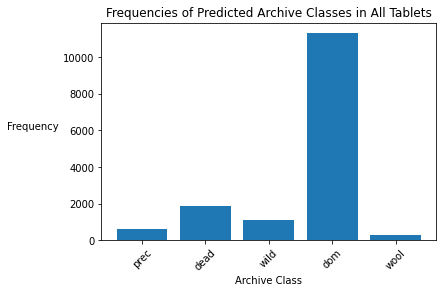

In [ ]:
plt.xlabel('Archive Class')
plt.ylabel('Frequency', rotation=0, labelpad=30)
plt.title('Frequencies of Predicted Archive Classes in All Tablets')
plt.xticks(rotation=45)
labels = list(set(predicted_df['prediction']))
counts = [predicted_df.loc[predicted_df['prediction'] == label].shape[0] for label in labels]
plt.bar(labels, counts);

The below chart displays the actual frequencies of the different archives in the test set. As mentioned previously, it is visually obvious that there are many texts in the domestic archive, with comparatively very few texts in all of the other archives.

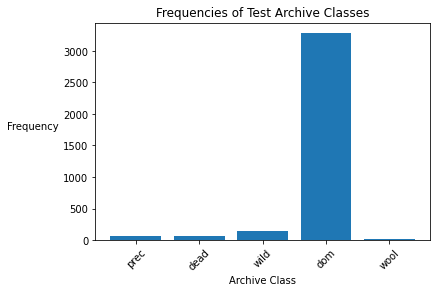

In [ ]:
plt.xlabel('Archive Class')
plt.ylabel('Frequency', rotation=0, labelpad=30)
plt.title('Frequencies of Test Archive Classes')
plt.xticks(rotation=45)
test_counts = [(class_series[X_test.index])[class_series == label].count() for label in labels]
plt.bar(labels, np.asarray(test_counts));

Below is a chart of the predicted frequency of the different archives by our ML model in the test set. Our predicted frequency looks very similar to the actual frequency above, which is good.

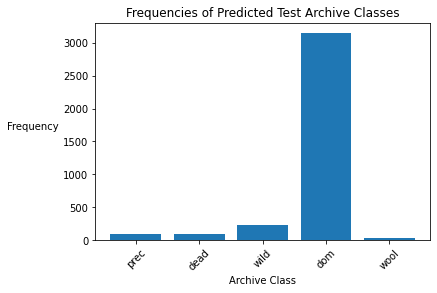

In [ ]:
plt.xlabel('Archive Class')
plt.ylabel('Frequency', rotation=0, labelpad=30)
plt.title('Frequencies of Predicted Test Archive Classes')
plt.xticks(rotation=45)
test_pred_counts = [predicted_df.loc[X_test.index].loc[predicted_df['prediction'] == label].shape[0] for label in labels]
plt.bar(labels, np.asarray(test_pred_counts));

Unfortunately, since our texts skew so heavily towards being part of the domestic archive, most of the other archives end up being overpredicted (i.e. our model says a text is part of that archive when it is actually not). Below we can see that the domestic archive is the only archive whose texts are not overpredicted.

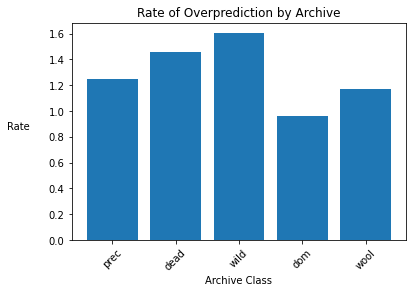

In [ ]:
plt.xlabel('Archive Class')
plt.ylabel('Rate', rotation=0, labelpad=30)
plt.title('Rate of Overprediction by Archive')
plt.xticks(rotation=45)
rate = np.asarray(test_pred_counts)/np.asarray(test_counts)*sum(test_counts)/sum(test_pred_counts)
plt.bar(labels, rate);

### 5.3 Accuracy By Archive

The accuracies for the dead and wild archives are relatively low. This is likely because those texts are being misclassified into the domestic archive, our largest archive, since all three of these archives deal with animals. The wool and precious archives have decent accuracies.

In [ ]:
f.score(X_test[class_series == 'dead'], y_test[class_series == 'dead'])

0.734375

In [ ]:
f.score(X_test[class_series == 'dom'], y_test[class_series == 'dom'])

0.9449010654490106

In [ ]:
f.score(X_test[class_series == 'wild'], y_test[class_series == 'wild'])

0.7410071942446043

In [ ]:
f.score(X_test[class_series == 'wool'], y_test[class_series == 'wool'])

0.8333333333333334

In [ ]:
f.score(X_test[class_series == 'prec'], y_test[class_series == 'prec'])

0.9264705882352942

We can also look at the confusion matrix. A confusion matrix is used to evaluate the accuracy of a classification. The rows denote the actual archive, while the columns denote the predicted archive. 

Looking at the first column: 
- 73.44% of the dead archive texts are predicted correctly
- 1.31% of the domestic archive texts are predicted to be part of the dead archive
- 1.47% of the wild archive texts are predicted to be part of the dead archive
- 1.43% of the wool archive texts are predicted to be part of the dead archive
- none of the precious archive texts are predicted to be part of the dead archive

In [ ]:
from sklearn.metrics import confusion_matrix
archive_confusion = confusion_matrix(y_test, f.predict(X_test), normalize='true')

In [ ]:
archive_confusion

array([[0.734375  , 0.171875  , 0.015625  , 0.0625    , 0.015625  ],
       [0.0130898 , 0.94490107, 0.00487062, 0.03531202, 0.00182648],
       [0.01470588, 0.05882353, 0.92647059, 0.        , 0.        ],
       [0.01438849, 0.21582734, 0.02158273, 0.74100719, 0.00719424],
       [0.        , 0.08333333, 0.08333333, 0.        , 0.83333333]])

This is the same confusion matrix converted into real numbers of texts. Since the number of domestic archive texts is so high, even a small bit of misclassification of the domestic archive texts can overwhelm the other archives.

For example, even though only 1.3% of the domestic archive texts are predicted to be part of the dead archive, that corresponds to 43 texts, while the 73% of the dead archive texts that were predicted correctly correspond to just 47 texts. As a result, about half of the texts that were predicted to be part of the dead archive are incorrectly classified.

In [ ]:
confusion_matrix(y_test, f.predict(X_test), normalize=None)

array([[  47,   11,    1,    4,    1],
       [  43, 3104,   16,  116,    6],
       [   1,    4,   63,    0,    0],
       [   2,   30,    3,  103,    1],
       [   0,    2,    2,    0,   20]])

## 6 Save Results in CSV file & Pickle